# $\chi^2$ Test

In [1]:
from imprint.nb_util import setup_nb

# setup_nb is a handy function for setting up some nice plotting defaults.
setup_nb()
import scipy.stats
import matplotlib.pyplot as plt

import imprint as ip
from imprint.models.chisq import ChiSqTest

In this tutorial, we study the $\chi^2$ test under the Gaussian data assumption.
Let $X_1,\ldots, X_n \sim \mathcal{N}(0, \sigma^2)$ be i.i.d. samples
with $\sigma^2$ unknown.
We wish to test the hypothesis that $H_0: \sigma \leq \sigma_0$ for fixed $\sigma_0$.
The $\chi^2$ test constructs the usual variance estimator as the test statistic:
$$
\begin{align*}
    T := \sum\limits_{i=1}^n (X_i - \bar{X})^2
\end{align*}
$$
and rejects the null if $T > t^*$ where $t^* := \sigma_0^2 (\chi^2_{n-1})^{-1}(1-\alpha)$,
i.e. the $1-\alpha$ quantile of $\chi^2_{n-1}$ and scaled by $\sigma_0^2$.
To follow the convention of $\lambda$-indexing, 
we let $\lambda := -t^*$ so that increasing $\lambda$ increases the rejection set.

In the normal family $\{\mathcal{N}(0, \sigma^2) : \sigma \in S\}$ for some set $S$,
the natural parameter is
$$
\begin{align*}
    \theta(\sigma) := -\frac{1}{2\sigma^2}
\end{align*}
$$
Letting $\theta_0 := \theta(\sigma_0)$, the null hypothesis is then
$H_0: \theta \leq \theta_0$.

In [122]:
alpha = 0.025  # target nominal level
sigma_0 = 2  # fixed boundary of null hypothesis
n_samples = 10  # number of samples
n_gridpts = 1000  # number of grid-points
n_sims = 2**13  # number of simulations
theta_min = -0.5
theta_max = -0.5 / (sigma_0**2)

# construct grid away from 0 to have a well-defined model.
grid = ip.cartesian_grid(
    theta_min=[0, theta_min],
    theta_max=[0, theta_max],
    n=[1, n_gridpts],
    null_hypos=[ip.hypo(f"x1 <= {theta_max}")],
)
lam = -(sigma_0**2) * scipy.stats.chi2.isf(alpha, df=n_samples - 1)

DEBUG:imprint.grid:[worker_id=None] 
_gen_short_uuids(n=1000, worker_id=1, t=1674606039, n_bits=18, worker_bits=18) = [4397586296768561152 4397586296768561153 4397586296768561154, ...]:


As a sanity check, we plot the true Type I Error curve as a function of $\theta$.

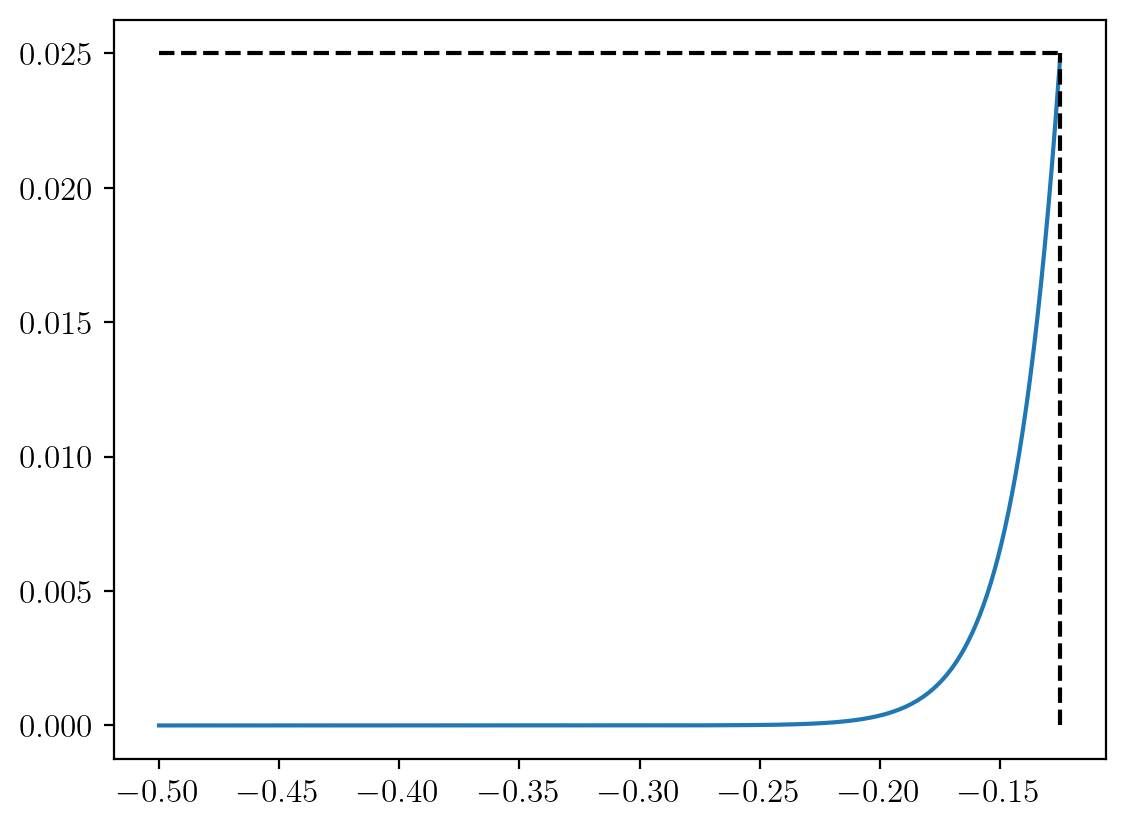

In [123]:
theta = grid.get_theta()[:, 1]
true_tie = scipy.stats.chi2.sf(2 * lam * theta, df=n_samples - 1)
plt.plot(theta, true_tie)
plt.vlines(x=theta_max, ymin=0, ymax=alpha, linestyles="--", color="black")
plt.hlines(y=alpha, xmin=theta_min, xmax=theta_max, linestyles="--", color="black")

In [124]:
rej_df = ip.validate(
    ChiSqTest, grid, lam, K=n_sims, model_kwargs={"n_samples": n_samples}
)
rej_df.tail()

,tie_sum,tie_est,tie_cp_bound,tie_bound
995,235,0.0235,0.027268,0.027617
996,242,0.0242,0.028018,0.028377
997,251,0.0251,0.028982,0.029351
998,255,0.0255,0.029410,0.029785
999,257,0.0257,0.029624,0.030002


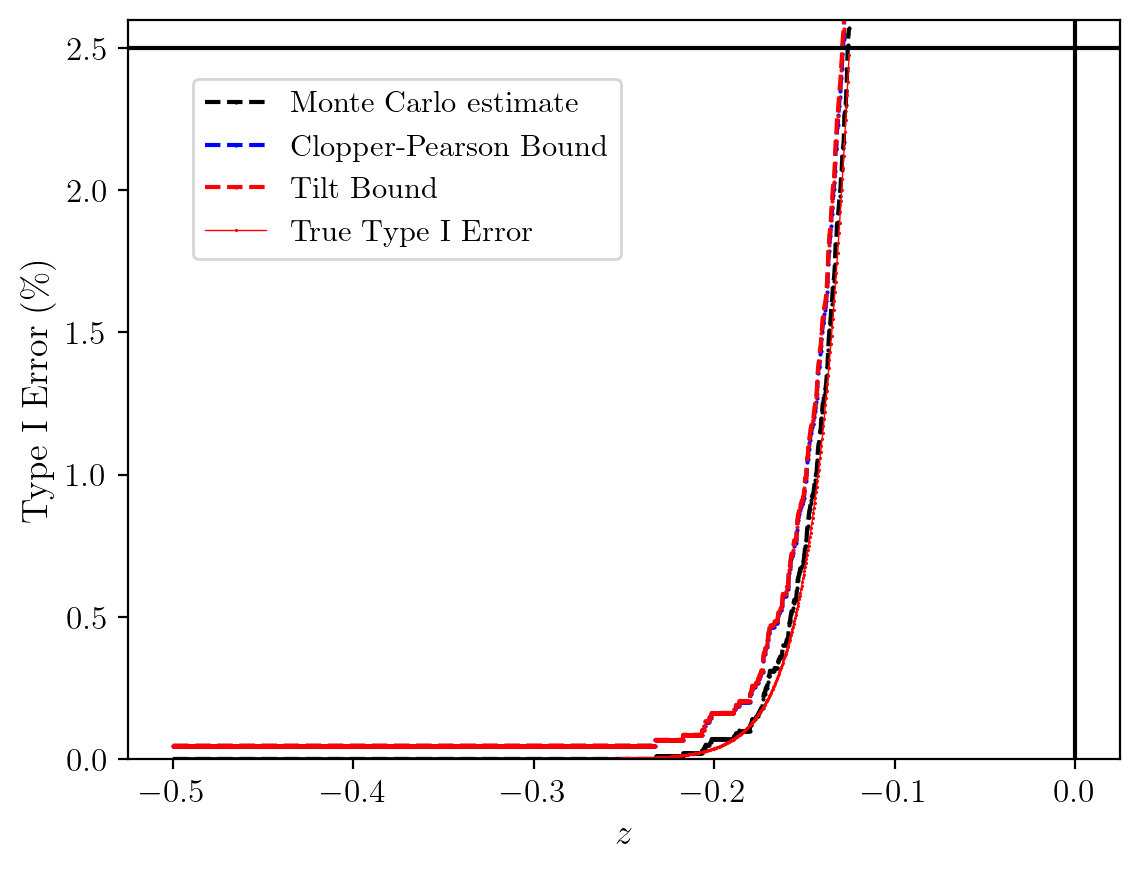

In [125]:
g_rej = grid.add_cols(rej_df)
g_rej.df.sort_values("theta1", inplace=True)
true_err = scipy.stats.chi2.sf(2 * lam * theta, df=n_samples - 1)

plt.plot(
    g_rej.df["theta1"],
    100 * g_rej.df["tie_est"],
    "k--o",
    markersize=0.5,
    label="Monte Carlo estimate",
)
plt.plot(
    g_rej.df["theta1"],
    100 * g_rej.df["tie_cp_bound"],
    "b--o",
    markersize=0.5,
    label="Clopper-Pearson Bound",
)
plt.plot(
    g_rej.df["theta1"],
    100 * g_rej.df["tie_bound"],
    "r--o",
    markersize=0.5,
    label="Tilt Bound",
)
plt.plot(
    g_rej.df["theta1"],
    100 * true_err,
    "r-*",
    linewidth=0.5,
    markersize=0.5,
    label="True Type I Error",
)
plt.axhline(2.5, color="k")
plt.axvline(0, color="k")
plt.ylim([0, 2.6])
plt.legend(fontsize=11, bbox_to_anchor=(0.05, 0.94), loc="upper left")
plt.xlabel("$z$")
plt.ylabel(r"Type I Error (\%)")
plt.show()